# Classification of Forest Fires and Floods Images with Logistic Regression

By Marie Anand, Shree Patel, and Sophia Zhang

This notebook walks through logistic regression model development for the differentiation and classification of forest fires and floods images. Included in this notebook are feature correlation calculations, vanilla logistic regression and performance analysis, gradient descent logistic regression, hyperparameter tuning, principal componenet analysis, and logistic regression modeling and performance with the aforementioned additional data cleaning and optimization methods. 

### Necesary Imports

In [1]:
from data_utils import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from feature_utils import *
from functions import *
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score


### Loading the Dataset and Mapping Correlation

In [2]:
# function definitions

def calculate_correlations(data, target='Label'):
    """
    calculates how each features correlates with the target variable

    Parameters
    ----------
    data: pd.DataFrame
        dataframe including the features and target
    target: pd.Series
        'Label': column label for the target

    Returns
    ----------
    correlation_df: pd.DataFrame   
        dataframe of the features' correlation with the target variable 
    """
    correlations = {}
    for column in data.columns:
        if column != target and pd.api.types.is_numeric_dtype(data[column]):
            correlation = data[[column, target]].corr().iloc[0, 1]
            correlations[column] = correlation
    correlation_df = pd.DataFrame.from_dict(correlations, orient='index', columns=['Correlation with Label'])
    
    print(correlation_df.sort_values(by='Correlation with Label', ascending=False))
    
    return correlation_df

,Sobel_Edges,LBP,Red_Log,Green_Log,Gabor,Label
count,14008.000000,14008.000000,14008.000000,14008.000000,14008.000000,14008.000000
mean,1.119788,16.499286,7.578712,7.851270,9.645750,0.500000
std,0.750514,1.194180,0.699656,0.669035,6.462807,0.500018
min,0.013548,9.525641,4.129490,4.501692,0.267417,0.000000
25%,0.554715,15.769624,7.128637,7.416543,5.035243,0.000000
50%,0.915679,16.412236,7.610338,7.900751,8.179345,0.500000
75%,1.550101,17.318433,8.093824,8.346411,12.861070,1.000000
max,7.832202,21.386887,9.985896,10.135856,78.937504,1.000000


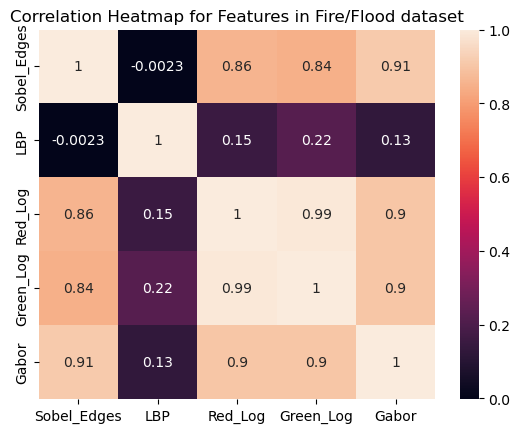

In [3]:
# read in the dataset generated from feature engineering python script
logistic_features = pd.read_csv("socal_fires_midwest_floods.csv")

#Correlation Heatmap for all features
features_only = logistic_features.drop(columns=['Label'])
heatmap = sns.heatmap(features_only.corr(), annot=True)
heatmap.set_title('Correlation Heatmap for Features in Fire/Flood dataset')

logistic_features.describe()

We find that a lot of features have a high degree of collinearity. This may not be useful for our modeling, and this means we may need to implement PCA down the line. However, for the sake of having a control, let us implement a logistic regression model on the data. 

In [4]:
columns_list = logistic_features.columns.tolist()
correlation_df = calculate_correlations(logistic_features[columns_list])

             Correlation with Label
Sobel_Edges                0.438989
Red_Log                    0.297080
Gabor                      0.251787
Green_Log                  0.228863
LBP                       -0.631108


Given the correlation dataframe, it seems that the model may rely more heavily on the sobel edge values for generating its predictions

### Test, Train Split and Preparing for Modeling

In [5]:
# separate the features from the target
X = logistic_features.drop('Label', axis=1)
y = logistic_features['Label']

#Scaling and Normalizing the data so that all feature data is between 0 and 1
scaler = MinMaxScaler(feature_range = (0,1))
sn_X = scaler.fit_transform(X)
sn_X = pd.DataFrame(sn_X, columns=X.columns, index=X.index)

sn_X.describe()

,Sobel_Edges,LBP,Red_Log,Green_Log,Gabor
count,14008.000000,14008.000000,14008.000000,14008.000000,14008.000000
mean,0.141487,0.587935,0.588966,0.594512,0.119211
std,0.095990,0.100679,0.119468,0.118746,0.082151
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.069215,0.526419,0.512114,0.517353,0.060605
50%,0.115382,0.580596,0.594366,0.603294,0.100571
75%,0.196524,0.656996,0.676923,0.682394,0.160082
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# splitting a portion of the data to save for validation of our models

X_train, X_valid, y_train, y_valid = train_test_split(sn_X, y,test_size=0.20, random_state=42, stratify=y)

### Vanilla Logistic Regression

In [7]:
# function definitions: loss functions

def rmse(predicted, actual):
    """
    Calculates RMSE from actual (dataframe) and predicted (model generated) values

    Parameters
    ----------
    predicted: np.array
        the model's predictions for the label of each datapoint 
    actual: np.array  
        the original labelled data's label for each of the data points 

    Returns
    ----------
    RMSE: np.float
        value to quantify the error in the model
    """
    return np.sqrt(mean_squared_error(actual, predicted))  

def cross_entropy(predicted, actual):
    '''
    Calculates the classification error through the cross entropy loss 

    Parameters
    ----------
    predicted: np.array
        the model's predictions for the label of each datapoint 
    actual: np.array  
        the original labelled data's label for each of the data points 

    Returns
    ----------
    loss: np.float
        quantifies the error in the model
    '''
    epsilon = 1e-15
    y_pred = np.clip(predicted, epsilon, 1 - epsilon)
    
    # Check if binary or multi-class
    if actual.ndim == 1:  # Binary classification (only one column of targets)
        # Compute binary cross-entropy
        loss = -np.mean(actual * np.log(y_pred) + (1 - actual) * np.log(1 - y_pred))
    else:  
        # Compute multi-class cross-entropy
        loss = -np.mean(np.sum(actual * np.log(y_pred), axis=1))
    
    return loss

Training CE: 2.91
Validation CE: 3.02
Training Accuracy score: 0.92
              precision    recall  f1-score   support

      Floods       0.92      0.91      0.92      5603
       Fires       0.91      0.93      0.92      5603

    accuracy                           0.92     11206
   macro avg       0.92      0.92      0.92     11206
weighted avg       0.92      0.92      0.92     11206

Validation Accuracy score: 0.91
              precision    recall  f1-score   support

      Floods       0.91      0.91      0.91      1401
       Fires       0.91      0.91      0.91      1401

    accuracy                           0.91      2802
   macro avg       0.91      0.91      0.91      2802
weighted avg       0.91      0.91      0.91      2802



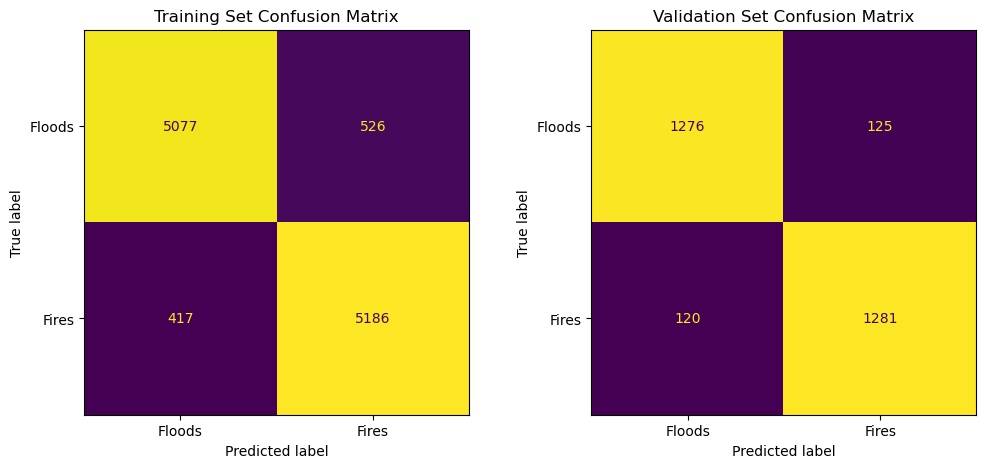

In [16]:
# fit a regression model from the scikit-learn built in model
model = LogisticRegression()
model.fit(X_train, y_train)

# generate predictions on the training set and the validation set
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)

# calculate the cross enbtropy (loss) for the training and validation set
train_ce = cross_entropy(y_train_pred, y_train)
test_ce = cross_entropy(y_valid_pred, y_valid)

# visualize the model's performance on both categories
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_valid, y_valid_pred)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(train_cm, display_labels=["Floods", "Fires"]).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Training Set Confusion Matrix")
ConfusionMatrixDisplay(test_cm, display_labels=["Floods", "Fires"]).plot(ax=ax[1], colorbar=False)
ax[1].set_title("Validation Set Confusion Matrix")

print(f"Training CE: {train_ce:.2f}")
print(f"Validation CE: {test_ce:.2f}")

train_accuracy = accuracy_score(y_train, y_train_pred)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Training Accuracy score: {train_accuracy:.2f}")
print(classification_report(y_train, y_train_pred, target_names=["Floods", "Fires"]))

print(f"Validation Accuracy score: {valid_accuracy:.2f}")
print(classification_report(y_valid, y_valid_pred, target_names=["Floods", "Fires"]))

plt.show()

From this, we see an F1 score of 0.91, which suggests that our model is performing binary classification splendidly. However, we did see a handful of correlated features in the heatmap earlier. Let us see if we can improve the fit by using a couple of techniques to tune the model. 

### Logistic Regression with PCA, Gradient Descent, and Hyperparameter Tuning

In this section, the previous model will be altered with a variety of techniques to see if the performance improves

In [9]:
# function defintions 

def sigmoid(z):
    '''
    calculates a mapping between 0 to 1 

    Parameters
    -----------
    z: np.array
        linear model calculated by the dotproduct of features with weights and adding a bias term

    Returns 
    -----------
    prediction: np.float
        probability like output to classify which class a data point belongs to
    '''
    return 1 / (1 + np.exp(-z))

def gradient_descent_logistic(X, y, num_classes, learning_rate=1, reg=0.001, iterations=1000):
    """
    runs a logistic model with gradient descent from scratch

    Parameters
    ----------
    X: np.array
        features for each datapoint 
    y: np.array
        target variable (in this case, label)
    num_classes: int
        number of unique classes expected in the dataset 
    learning_rate = float
        speed with which the models learns the data (i.e. does it move along the gradient descent curve quickly or slowly?)
    reg: float
        loss function penalty
    iterations: int
        number of times the fitting and updating procedure is performed before results are output

    Returns
    ---------
    weights: np.array
        the weight of each feature in the dataset on the target variable 
    bias: np.array 
        constants that may shift the model and increase its ability to learn more complex relationships 
    """
    m, n = X.shape
    if num_classes == 1:  # Binary Classification
        weights = np.zeros(n)  # Shape: (n_features,)
        bias = 0   # Scalar bias
    else:      
        weights = np.zeros((n, num_classes))  # n features, num_classes outputs
        bias = np.zeros(num_classes)         # One bias per class
    for i in range(iterations):
        linear_model = np.dot(X, weights) + bias
        y_pred = sigmoid(linear_model)
        dw = (1 / m) * np.dot(X.T, (y_pred - y)) + (reg / m) * weights 
        db = (1 / m) * np.sum(y_pred - y, axis = 0)
        # print(f"Gradient dw: {dw}, Gradient db: {db}")  # Debugging
        weights -= learning_rate * dw
        bias -= learning_rate * db
    return weights, bias

def apply_pca(X_train, X_test, n_components=5):
    '''
    captures the variance of the data with a specified number of principal components

    Parameters
    -----------
    X_train: np.array 
        features of the training dataset
    X_test: np.array  
        features of the test dataset
    n_components: int
        number of principal components to fit the data to 
    '''
    pca = PCA(n_components=n_components)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    print("Explained variance by PCA components:", pca.explained_variance_ratio_)
    return X_train, X_test, pca.explained_variance_ratio_, pca

def visualize_pca(X_pca, y, title="PCA Visualization for Floods and Fires Classification"):
    '''
    plot the PCA principal components
    
    Parameters
    ---------
    X_pca: np.array
        training dataset after PCA has been performed
    y: np.array
        target variable (in this case, label)
    title: string
        Desired Plot Title
    '''
    plt.figure(figsize=(8, 8))

    if X_pca.shape[1] >= 3:
        # 3D visualization
        ax = plt.subplot(111, projection='3d')
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', alpha=0.8)
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
    else:
        # 2D visualization
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.8)
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    
    plt.title(title)
    plt.colorbar(scatter, label="Class Labels")
    plt.grid(True)
    plt.show()

def predict(X, weights, bias):
    linear_model = np.dot(X, weights) + bias
    y_pred = sigmoid(linear_model)
    return (y_pred > 0.5).astype(int)

def generate_test_preds(test_set, weights, bias, pca_obj):
    '''
    *For use with the pca / kfold function when a test_Set is provided*

    generates test_set_predictions using the trained model

    Parameters
    ----------
    test_set: np.array 
        dataset containing unseen data to test the model
    weights: np.array 
        calculated from gradient_descent_logistic to represent the weight of each feature
    bias: np.array
        calculated from gradient_descent_logistic to allow the model to fit more complex data
    pca_obj: np.array 
        scaling factors to fit the test set with the same PCA scale as training data 

    Returns
    -------
    None
    '''
    test_scales = scaler.fit_transform(test_set)
    test_features = pca_obj.transform(test_scales)
    test_predictions = predict(test_features, weights, bias)
    output_path = "gradient_logistic_w_pca_kfold_images_fire_floods_predictions.csv"
    pd.DataFrame(test_predictions).to_csv(output_path, index=False, header=False)

def calculate_f1_scores(y_true, y_pred, average='macro'):
    """
    Calculate precision, recall, and F1 scores for multi-class classification.

    Parameters
    ----------
    - y_true: Ground truth labels (1D array).
    - y_pred: Predicted labels (1D array).
    - average: Averaging method ('macro', 'weighted', 'micro', or None).

    Returns
    --------
    - precision: Precision score.
    - recall: Recall score.
    - f1: F1 score.
    """
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    
    print(f"Precision ({average}): {precision:.4f}")
    print(f"Recall ({average}): {recall:.4f}")
    print(f"F1 Score ({average}): {f1:.4f}")
    
    return precision, recall, f1


def apply_k_fold(X, y, k, num_classes, learning_rate=1, reg=0.001, iterations=1000, test_set=None):
    '''
    applied k-fold cross validation to increase the confidence of predictions 
    
    Parameters
    ----------
    X: np.array
        features for each datapoint 
    y: np.array
        target variable (in this case, label)
    k: int
        number of folds to perform for cross validation
    num_classes: int
        number of unique classes expected in the dataset 
    learning_rate = float
        speed with which the models learns the data (i.e. does it move along the gradient descent curve quickly or slowly?)
    reg: float
        loss function penalty
    iterations: int
        number of times the fitting and updating procedure is performed before results are output
    test_set: np.array
        default None, allows model to be used for predicting performance on unseen data

    Returns
    ---------
    avg_results: float
        average results obtained for each fold of the validation process
    '''
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}  # Initialize storage
    fold_num = 1 

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        weights, bias = gradient_descent_logistic(X_train, y_train, num_classes, learning_rate, reg, iterations)

        # Predict on validation set
        y_valid_pred = predict(X_val, weights, bias)
        
        # Compute and append metrics
        accuracy = accuracy_score(y_valid_pred, y_val)
        precision, recall, f1 = calculate_f1_scores(y_val, y_valid_pred, average='macro')
        metrics['accuracy'].append(accuracy)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1'].append(f1)
        
        print(f"\nMetrics for Fold {fold_num}:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")

        fold_num += 1

        if test_set is not None and not test_set.empty:
            generate_test_preds(test_set, weights, bias, pca_obj)

    avg_results = {metric: np.mean(values) for metric, values in metrics.items()}

    print("\nCross-Validation Results (Averages):")
    for metric, value in avg_results.items():
        print(f"{metric.capitalize()}: {value:.4f}")

    return avg_results

#### HyperParameter Tuning

In [10]:
# Hyperparameters to tune
learning = [0.01, 0.05, 0.1, 0.2, 1]
regs = [0.001, 0.01, 0.1, 1, 10]

top_accuracy = 0
params = {}
num_classes = 1

# Looping over hyperparameters
for rates in learning:
    for reg in regs:
        weights, bias = gradient_descent_logistic(X_train, y_train, num_classes, rates, reg)
            
        y_pred_ht = predict(X_valid, weights, bias)
            
        accuracy = accuracy_score(y_valid, y_pred_ht)
                
        if accuracy > top_accuracy:
            top_accuracy = accuracy
            params = {'learning_rate': rates, 'regularization': reg}

print(f"Tuned Parameters: {params}")
print(f"Accuracy: {top_accuracy:.4f}")

Tuned Parameters: {'learning_rate': 1, 'regularization': 0.001}
Accuracy: 0.8983


Knowing that these hyperparameters are best for modeling the current data, they will be used with future modeling efforts

Explained variance by PCA components: [0.76482196 0.18622139 0.03678983 0.01076145]


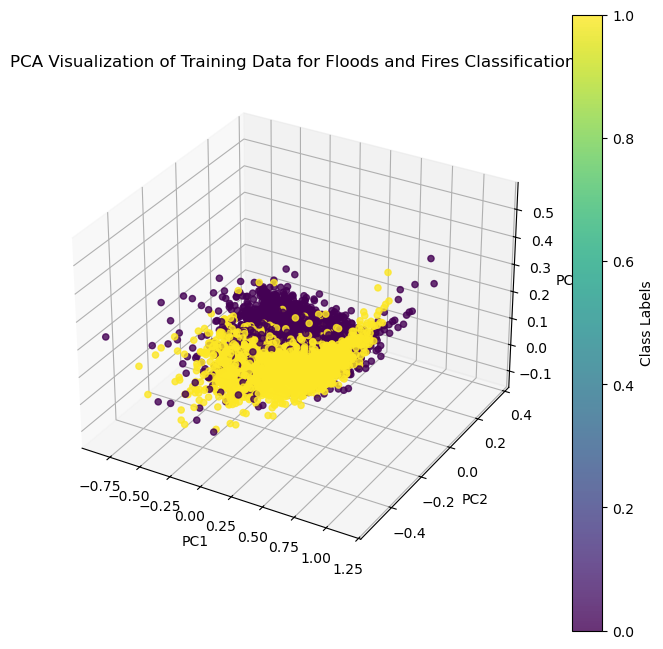

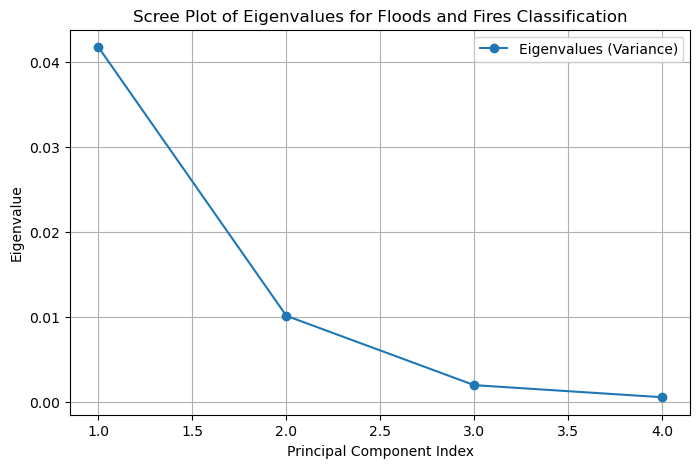

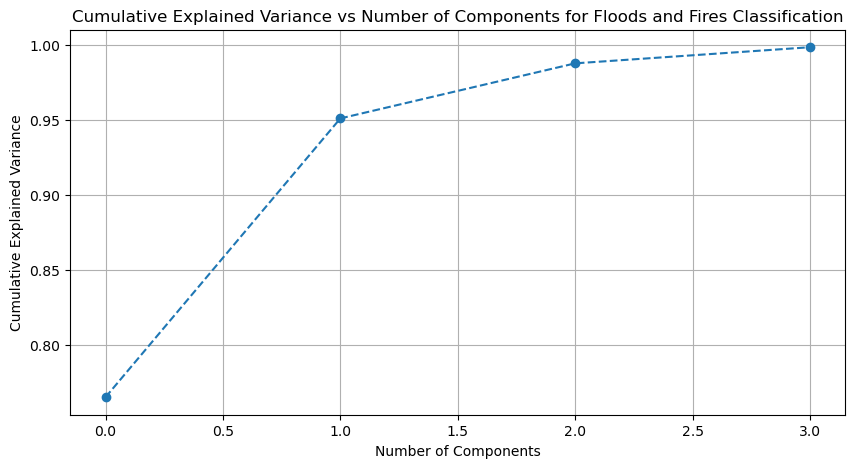

Number of components for 95% variance: 1


In [11]:
#Performing PCA on training and validation set 
if X_train.shape[1] > 4:  
    X_train_pca, X_valid_pca, pca_ratio, pca_obj = apply_pca(X_train, X_valid, n_components=4)

if X_train_pca.shape[1] >= 2:
    visualize_pca(X_train_pca, y_train, title="PCA Visualization of Training Data for Floods and Fires Classification")

#Plotting the cumulative variance
eigenvalues = pca_obj.explained_variance_

# Scree Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', label='Eigenvalues (Variance)')
plt.title("Scree Plot of Eigenvalues for Floods and Fires Classification")
plt.xlabel("Principal Component Index")
plt.ylabel("Eigenvalue")
plt.grid()
plt.legend()
plt.show()


#Calculating cumulative variance 
cumulative_explained_variance = np.cumsum(pca_ratio)

# Plot cumulative explained variance to see effect of each feature on variance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs Number of Components for Floods and Fires Classification')
plt.grid(True)
plt.show()

n_components = np.argmax(cumulative_explained_variance >= 95) + 1
print(f"Number of components for 95% variance: {n_components}")

These plots show that most of the variance is captured in one feature. Through our analysis, we have determined that 3 components is the ideal number to use, given that our results did not improve with the addition of more components

Training CE: 2.85
Training Accuracy score: 0.92
              precision    recall  f1-score   support

      Floods       0.92      0.91      0.92      5603
       Fires       0.91      0.92      0.92      5603

    accuracy                           0.92     11206
   macro avg       0.92      0.92      0.92     11206
weighted avg       0.92      0.92      0.92     11206

Validation CE: inf
Validation Accuracy score: 0.92
              precision    recall  f1-score   support

      Floods       0.92      0.92      0.92      1401
       Fires       0.92      0.92      0.92      1401

    accuracy                           0.92      2802
   macro avg       0.92      0.92      0.92      2802
weighted avg       0.92      0.92      0.92      2802



/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return bound(*args, **kwds)
/home/shreepatel527/miniconda3/envs/data_project/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: Downcasting behavior in Series and DataFrame methods 'where', 'mask', and 'clip' is deprecated. In a future version this will not infer object dtypes or cast all-round floats to integers. Instead call result.infer_objects(copy=False) for object inference, or cast round floats explicitly. To opt-in to the future behavior, set `pd.set_option('

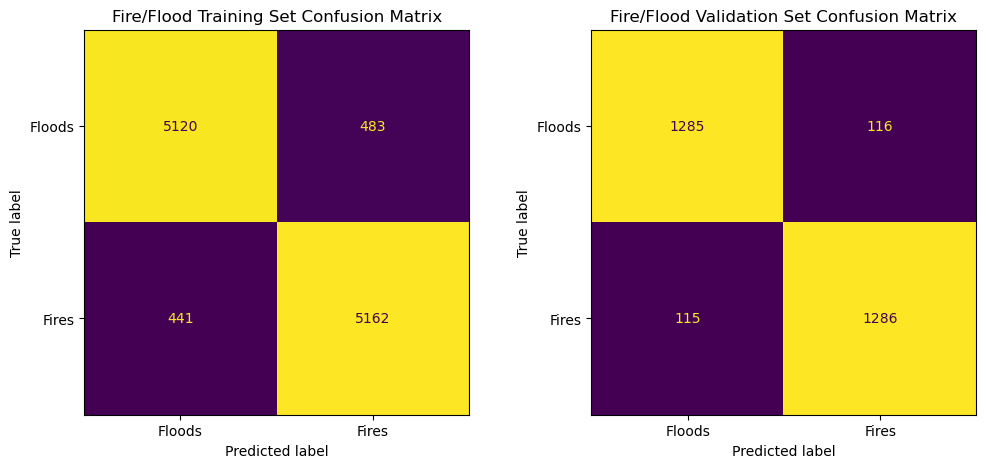

In [17]:
# Run the model with the tuned hyperparameters on the PCA data

# Modify this line to change learning rate and iterations
weights, bias = gradient_descent_logistic(X_train_pca, y_train, num_classes=1, learning_rate=1, reg=0.001, iterations=100000)
y_train_pred = predict(X_train_pca, weights, bias)
y_valid_pred = predict(X_valid_pca, weights, bias)

train_ce = cross_entropy(y_train, y_train_pred)
valid_ce = cross_entropy(y_valid, y_valid_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
print(f"Training CE: {train_ce:.2f}")
print(f"Training Accuracy score: {train_accuracy:.2f}")
print(classification_report(y_train, y_train_pred, target_names=["Floods", "Fires"]))
print(f"Validation CE: {valid_ce:.2f}")
print(f"Validation Accuracy score: {valid_accuracy:.2f}")
print(classification_report(y_valid, y_valid_pred, target_names=["Floods", "Fires"]))

train_cm = confusion_matrix(y_train, y_train_pred)
valid_cm = confusion_matrix(y_valid, y_valid_pred)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay(train_cm, display_labels=["Floods", "Fires"]).plot(ax=ax[0], colorbar=False)
ax[0].set_title("Fire/Flood Training Set Confusion Matrix")
ConfusionMatrixDisplay(valid_cm, display_labels=["Floods", "Fires"]).plot(ax=ax[1], colorbar=False)
ax[1].set_title("Fire/Flood Validation Set Confusion Matrix")
plt.show()

In [14]:
# attempt k-fold cross validation to see if there is improvement 
y_train = y_train.to_numpy()

results = apply_k_fold(X_train_pca, y_train, k=5, num_classes=1,learning_rate=1, reg=0.001)

print("Final Averaged Metrics:")
for metric, value in results.items():
    print(f"{metric.capitalize()}: {value:.4f}")

Precision (macro): 0.8965
Recall (macro): 0.8966
F1 Score (macro): 0.8965

Metrics for Fold 1:
  Accuracy: 0.8965
  Precision: 0.8965
  Recall: 0.8966
  F1 Score: 0.8965
Precision (macro): 0.9000
Recall (macro): 0.8997
F1 Score (macro): 0.8998

Metrics for Fold 2:
  Accuracy: 0.9000
  Precision: 0.9000
  Recall: 0.8997
  F1 Score: 0.8998
Precision (macro): 0.9094
Recall (macro): 0.9088
F1 Score (macro): 0.9089

Metrics for Fold 3:
  Accuracy: 0.9090
  Precision: 0.9094
  Recall: 0.9088
  F1 Score: 0.9089
Precision (macro): 0.8941
Recall (macro): 0.8944
F1 Score (macro): 0.8942

Metrics for Fold 4:
  Accuracy: 0.8942
  Precision: 0.8941
  Recall: 0.8944
  F1 Score: 0.8942
Precision (macro): 0.9089
Recall (macro): 0.9086
F1 Score (macro): 0.9085

Metrics for Fold 5:
  Accuracy: 0.9085
  Precision: 0.9089
  Recall: 0.9086
  F1 Score: 0.9085

Cross-Validation Results (Averages):
Accuracy: 0.9017
Precision: 0.9018
Recall: 0.9016
F1: 0.9016
Final Averaged Metrics:
Accuracy: 0.9017
Precision: